## '인공지능 보건의료 전문가를 위한 길라잡이' 실습

In [79]:
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt

In [80]:
from keras.datasets import fashion_mnist
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
labelNames = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

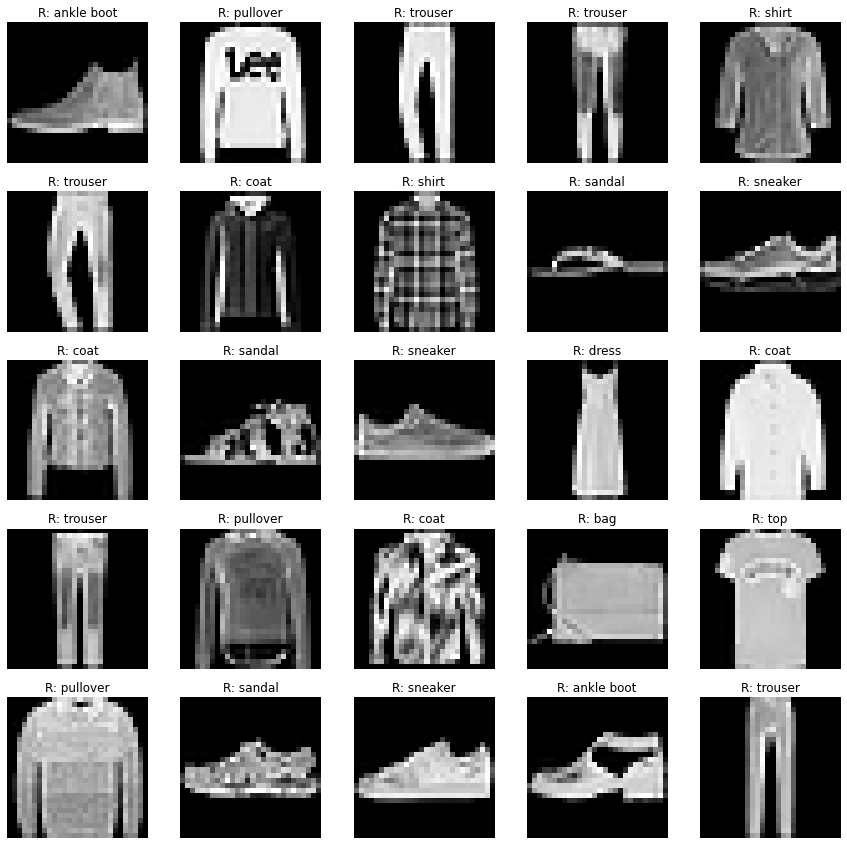

In [81]:
plt_row = 5
plt_col = 5
width = height = 28

#matplotlib 라이브러리의 rcParams 딕셔너리
plt.rcParams['figure.figsize'] = (15, 15)
f, axarr = plt.subplots(plt_row, plt_col)
for i in range(plt_row * plt_col):
  sub_plt = axarr[int(i/plt_row), i%plt_col]
  sub_plt.axis('off')
  sub_plt.imshow(testX[i].reshape(width, height), cmap='gray')
  sub_plt.set_title('R: ' + labelNames[testY[i]])
plt.show()

### DNN

In [82]:
#데이터 전처리

#flatten 28*28 images to a 784 vector for each image
width = height = 28
num_pixels = width * height
#0~255 범위의 데이터를 0~1로 rescale
trainX = trainX.reshape(60000, num_pixels).astype('float32')/255.0
testX = testX.reshape(10000, num_pixels).astype('float32')/255.0

#훈련셋과 검증셋 분리
valX = trainX[50000:]
valY = trainY[50000:]
trainX = trainX[:50000]
trainY = trainY[:50000]

#one hot encode outputs
num_classes = 10
trainY = np_utils.to_categorical(trainY, num_classes)
valY = np_utils.to_categorical(valY, num_classes)
testY = np_utils.to_categorical(testY, num_classes)

In [83]:
#DNN 모델

#Dropout : 순전파시 계층의 node들을 랜덤하게 제거함으로써 과적합 방지
from keras.layers import Dropout

def deep_perceptron_model_with_relu_dropout():
  model = Sequential()
  model.add(Dense(256, input_dim = num_pixels, kernel_initializer = 'normal', activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, kernel_initializer = 'normal', activation = 'softmax'))

  #compile model
  sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])
  return model

Epoch 1/20
782/782 - 8s - loss: 0.8966 - accuracy: 0.6621 - val_loss: 0.5347 - val_accuracy: 0.8041 - 8s/epoch - 10ms/step
Epoch 2/20
782/782 - 7s - loss: 0.4907 - accuracy: 0.8256 - val_loss: 0.4065 - val_accuracy: 0.8513 - 7s/epoch - 9ms/step
Epoch 3/20
782/782 - 7s - loss: 0.4287 - accuracy: 0.8452 - val_loss: 0.3902 - val_accuracy: 0.8592 - 7s/epoch - 9ms/step
Epoch 4/20
782/782 - 7s - loss: 0.3987 - accuracy: 0.8576 - val_loss: 0.3664 - val_accuracy: 0.8674 - 7s/epoch - 9ms/step
Epoch 5/20
782/782 - 7s - loss: 0.3769 - accuracy: 0.8640 - val_loss: 0.3716 - val_accuracy: 0.8685 - 7s/epoch - 9ms/step
Epoch 6/20
782/782 - 7s - loss: 0.3632 - accuracy: 0.8697 - val_loss: 0.3522 - val_accuracy: 0.8721 - 7s/epoch - 9ms/step
Epoch 7/20
782/782 - 7s - loss: 0.3479 - accuracy: 0.8742 - val_loss: 0.3482 - val_accuracy: 0.8756 - 7s/epoch - 9ms/step
Epoch 8/20
782/782 - 7s - loss: 0.3386 - accuracy: 0.8764 - val_loss: 0.3351 - val_accuracy: 0.8783 - 7s/epoch - 9ms/step
Epoch 9/20
782/782 - 7s

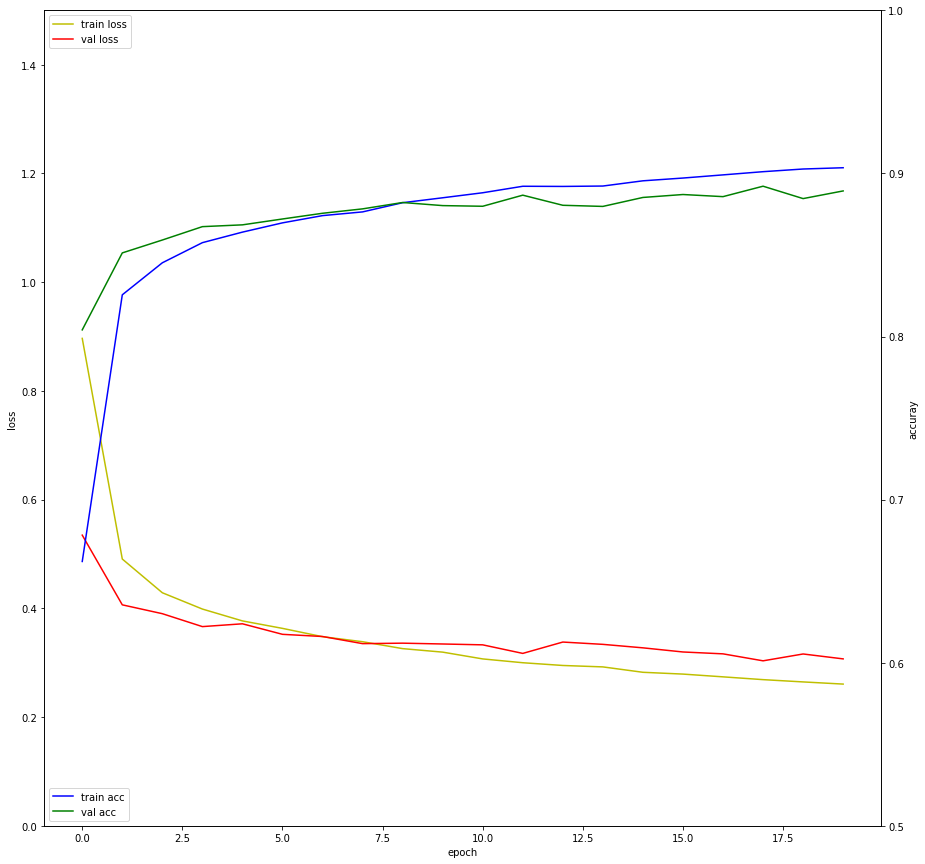

In [84]:
model = deep_perceptron_model_with_relu_dropout()

np.random.seed(7)

#fit the model
hist = model.fit(trainX, trainY, validation_data = (valX, valY), epochs=20, batch_size=64, verbose=2)

#학습과정 그래프
fig, loss_ax = plt.subplots()
#twinx : 두 개의 y 축이있는 플롯
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
loss_ax.set_ylim([0.0, 1.5])

acc_ax.plot(hist.history['accuracy'], 'b', label = 'train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'val acc')
acc_ax.set_ylim([0.5, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')
plt.show()

In [85]:
#evaluation of the model
scores = model.evaluate(testX, testY, verbose = 0)
print("Baseline Error: %.2f%%" %(100-scores[1]*100))

Baseline Error: 11.73%


### CNN

In [92]:
#28*28 데이터를 1차원 벡터로 전처리한 것 되돌려 놓기
#reshape to be [sample][pixel][width][height]
trainX = trainX.reshape(50000, 28, 28, 1)
valX = valX.reshape(10000, 28, 28, 1)
testX = testX.reshape(10000, 28, 28, 1)

In [94]:
#CNN model
def cnn_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape = (28, 28, 1)))
  model.add(BatchNormalization())
  model.add(Activation(activation = 'relu'))

  model.add(Conv2D(32, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation(activation = 'relu'))

  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation(activation = 'relu'))

  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation(activation = 'relu'))

  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  #compile model
  sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])
  return model

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


782/782 - 133s - loss: 0.5633 - accuracy: 0.7950 - val_loss: 0.3918 - val_accuracy: 0.8539 - 133s/epoch - 170ms/step
Epoch 2/20
782/782 - 130s - loss: 0.3809 - accuracy: 0.8627 - val_loss: 0.3245 - val_accuracy: 0.8834 - 130s/epoch - 166ms/step
Epoch 3/20
782/782 - 131s - loss: 0.3239 - accuracy: 0.8833 - val_loss: 0.2677 - val_accuracy: 0.9005 - 131s/epoch - 167ms/step
Epoch 4/20
782/782 - 134s - loss: 0.2943 - accuracy: 0.8942 - val_loss: 0.2722 - val_accuracy: 0.9024 - 134s/epoch - 171ms/step
Epoch 5/20
782/782 - 131s - loss: 0.2696 - accuracy: 0.9022 - val_loss: 0.2529 - val_accuracy: 0.9077 - 131s/epoch - 167ms/step
Epoch 6/20
782/782 - 131s - loss: 0.2469 - accuracy: 0.9110 - val_loss: 0.2371 - val_accuracy: 0.9094 - 131s/epoch - 167ms/step
Epoch 7/20
782/782 - 131s - loss: 0.2336 - accuracy: 0.9164 - val_loss: 0.2308 - val_accuracy: 0.9152 - 131s/epoch - 167ms/step
Epoch 8/20
782/782 - 130s - loss: 0.2223 - accuracy: 0.9199 - val_loss: 0.2419 - val_accuracy: 0.9149 - 130s/epoch 

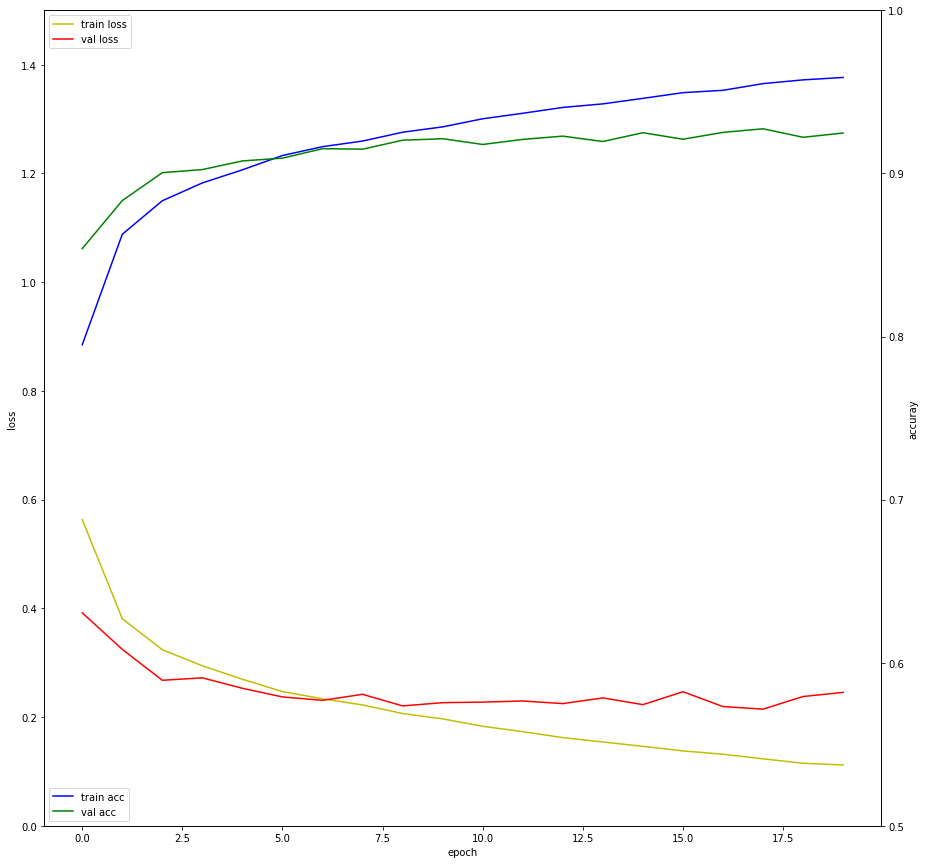

In [96]:
model = cnn_model()

#fit the model
hist = model.fit(trainX, trainY, validation_data = (valX, valY), epochs=20, batch_size=64, verbose=2)

#학습과정 그래프
fig, loss_ax = plt.subplots()
#twinx : 두 개의 y 축이있는 플롯
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
loss_ax.set_ylim([0.0, 1.5])

acc_ax.plot(hist.history['accuracy'], 'b', label = 'train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'val acc')
acc_ax.set_ylim([0.5, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')
plt.show()

In [97]:
#evaluation of the model
scores = model.evaluate(testX, testY, verbose = 0)
print("Baseline Error: %.2f%%" %(100-scores[1]*100))

Baseline Error: 7.82%


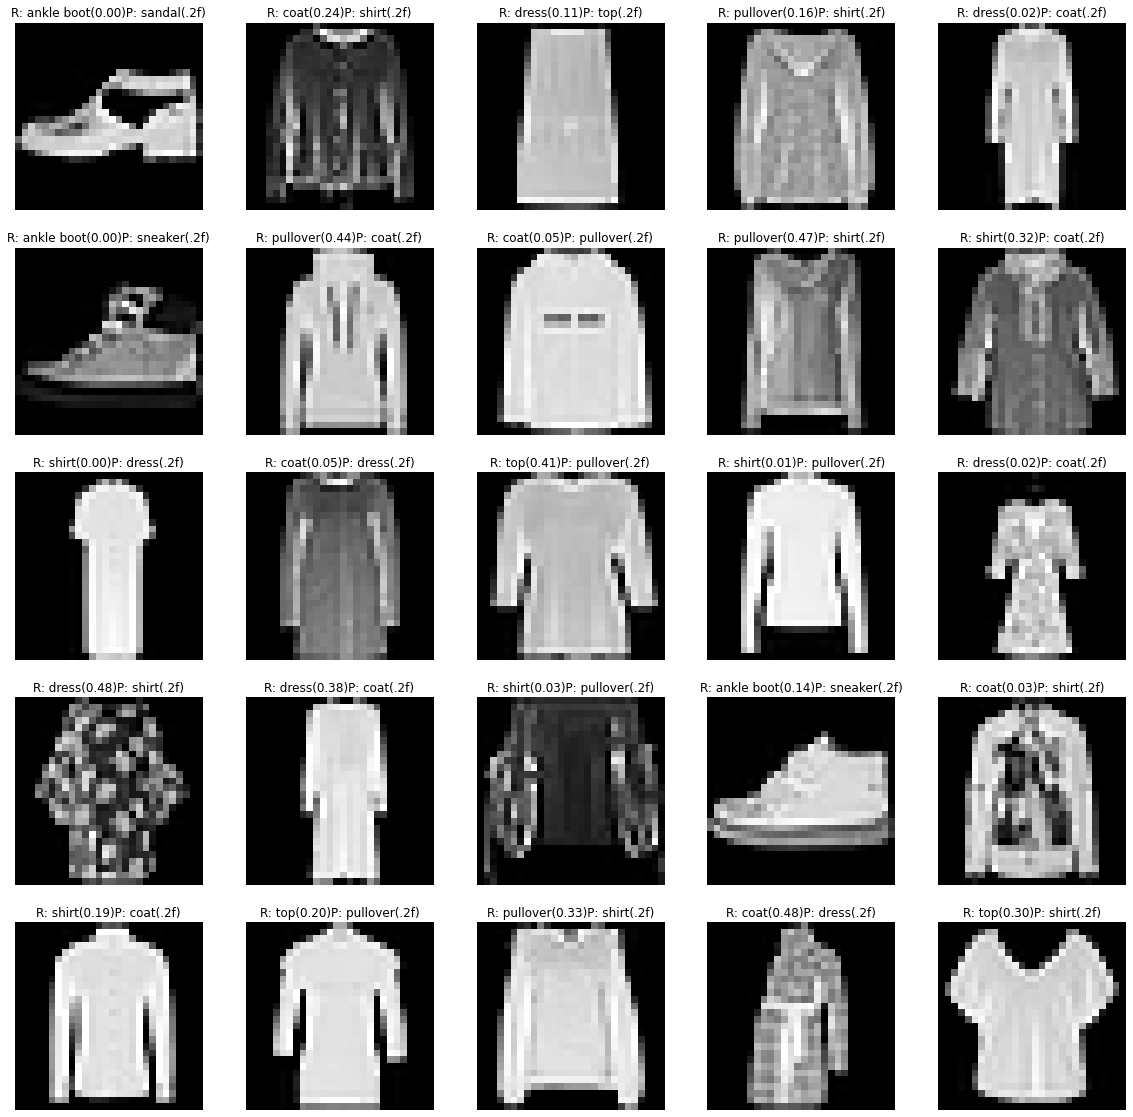

In [100]:
yhat_test = model.predict(testX, batch_size=32)
plt_row = 5
plt_col = 5
plt.rcParams['figure.figsize'] = (20, 20)
f, axarr = plt.subplots(plt_row, plt_col)
cnt = 0
i = 0

while cnt < (plt_row * plt_col):
  if np.argmax(testY[i]) == np.argmax(yhat_test[i]):
    i += 1
    continue
  sub_plt = axarr[(int)(cnt/plt_row), cnt%plt_col]
  sub_plt.axis('off')
  sub_plt.imshow(testX[i].reshape(width, height), cmap = 'gray')
  sub_plt_title = 'R: ' + labelNames[np.argmax(testY[i])] + '(%.2f)'%(yhat_test[i][np.argmax(testY[i])]) + 'P: ' + labelNames[np.argmax(yhat_test[i])] + '(.2f)'% (yhat_test[i][np.argmax(yhat_test[i])])
  sub_plt.set_title(sub_plt_title)
  i += 1
  cnt += 1
plt.show()